In [37]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import seaborn as sns
import matplotlib.pyplot as plt

#### Loading CTR Data for AB Test

In [ ]:
# Load the dat form the csv file
df_ab_test = pd.read_csv('ab_test_click_data.csv')

# Display the first rows of the DataFrame to cofirm it's load correctyly
print(df_ab_test.head())
print(df_ab_test.describe())

print(df_ab_test.groupby("group")[["user_id", "click"]].sum())
print(df_ab_test.groupby(['group', 'click']).size().reset_index(name='count'))

   user_id  click group            timestamp
0        1      1   exp  2024-01-01 00:00:00
1        2      0   exp  2024-01-01 00:01:00
2        3      1   exp  2024-01-01 00:02:00
3        4      0   exp  2024-01-01 00:03:00
4        5      1   exp  2024-01-01 00:04:00
            user_id         click
count  20000.000000  20000.000000
mean   10000.500000      0.405250
std     5773.647028      0.490953
min        1.000000      0.000000
25%     5000.750000      0.000000
50%    10000.500000      0.000000
75%    15000.250000      1.000000
max    20000.000000      1.000000
         user_id  click
group                  
con    150005000   1989
exp     50005000   6116
  group  click  count
0   con      0   8011
1   con      1   1989
2   exp      0   3884
3   exp      1   6116


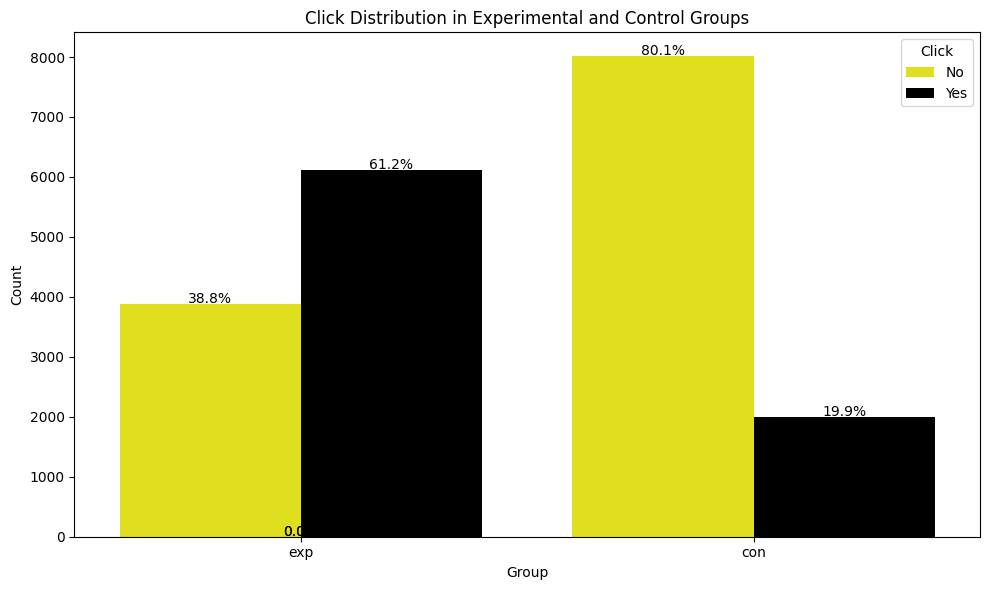

In [39]:
# Custom palette for yellow and black
palette = {0: "yellow", 1: "black"} # Assuming 0 is for no-click, 1 for click

# Plotting the click distribution for each group with the custom colors
plt.figure(figsize=(10, 6)) # width=10, height=6
# Count rows in DataFrame
# Group (con/exp) on x axis, count hue={0, 1} for (con/exp), use palette color
ax = sns.countplot(x="group", hue="click", data=df_ab_test, palette=palette)
plt.title("Click Distribution in Experimental and Control Groups")
plt.xlabel("Group")
plt.ylabel("Count")
# llabels=["No", "Yes"] => [0, 1] in hue values
plt.legend(title="Click", labels=["No", "Yes"])

# calculate the percentages and annotate the bars (count NAN values # count())
group_counts = df_ab_test.groupby(['group']).size()
group_click_counts = df_ab_test.groupby(['group', 'click']).size().reset_index(name='count')

for p in ax.patches:
    # height = number of count
    height = p.get_height()
    # Find the group and click type for the current bar
    group = 'exp' if p.get_x() < 0.5 else 'con'
    click = 1 if p.get_x() % 1 > 0.5 else 0
    total = group_counts.loc[group]
    # total = total{con, exp}
    percentage = 100 * height / total
    # ax.text(x, y, s, ha, color, fontsize)
    ax.text(
        p.get_x() + p.get_width() / 2., 
        height + 20, 
        f'{percentage:.1f}%', 
        ha="center", 
        color="black", 
        fontsize="10"
        )

plt.tight_layout()
plt.show()

#### Parameters of the Model from Power Analysis

In [40]:
# α: Bác bỏ giả thuyết vô hiệu (H₀) trong khi H₀ là đúng.
# vd: nếu thuốc thật ra không hiệu quả, thì chúng ta vẫn có cơ hội
# nói rằng nó có hiểu quả (kết luận sai).
alpha = 0.05
print("Alpha: significane level is: ", alpha)

# thuốc mới có làm giảm huyết áp tốt hơn thuốc cũ hay không
# thuốc cũ giảm huyết áp trung bình 10 mmHg
# quan tâm thuốc mới giúp giảm nhiều hơn ít nhất 1 mmHg nữa
delta = 0.1
print("Delta: minimum detectable effect is: ", delta)

Alpha: significane level is:  0.05
Delta: minimum detectable effect is:  0.1


#### Calculating Poolde Estimates for CLicks per Group

In [62]:
#N_con = df_ab_test[df_ab_test["group"] == "con"].shape[0]
#N_exp = df_ab_test[df_ab_test["group"] == "exp"].shape[0]

N_con = (df_ab_test["group"] == "con").sum()
N_exp = (df_ab_test["group"] == "exp").sum()

# computing the total number of clicks per group by suming 1's 
# specific in group
X_con = df_ab_test.groupby("group")["click"].sum().loc["con"]
X_exp = df_ab_test.groupby("group")["click"].sum().loc["exp"]

# printing this for visibility
print(df_ab_test.groupby("group")["click"].sum())
print("Number of user in Control: ", N_con)
print("Number of users in Eperimental: ", N_exp)
print("Number of clicks in control: ", X_con)
print("Number of clicks in experimental: ", X_exp)

group
con    1989
exp    6116
Name: click, dtype: int64
Number of user in Control:  10000
Number of users in Eperimental:  10000
Number of clicks in control:  1989
Number of clicks in experimental:  6116


#### Calculating Pooled Estimates for CLicks per Group

In [56]:
# computing the estimate of click probabilty per group
p_con_hat = X_con / N_con
p_exp_hat = X_exp / N_exp
print("Click Probability in Control Group: \n", p_con_hat)
print("Click Probability in Experimental Group: \n", p_exp_hat)

# computing the estimate of pooled clicked probability
p_pooled_hat = (X_con + X_exp) / (N_con + N_exp)
print("Pooled Click Probability: \n", p_pooled_hat)

Click Probability in Control Group: 
 0.1989
Click Probability in Experimental Group: 
 0.6116
Pooled Click Probability: 
 0.40525


#### Calculating Pooled Variance

In [57]:
# computing the estimate of pooled variance
pooled_variance = p_pooled_hat * (1-p_pooled_hat) * (1/N_con + 1/N_exp)
print("p^_pooled is: \n", p_pooled_hat)
print("pooled_variance is: \n", pooled_variance)

p^_pooled is: 
 0.40525
pooled_variance is: 
 4.82044875e-05


#### Calculating Standard Error and Test Statistics

In [58]:
# computing the standard error of the test
SE = np.sqrt(pooled_variance)
print("Standard Error is: \n", SE)

# computing the test statistics of Z-test
Test_stat = (p_con_hat - p_exp_hat) / SE
print("Test Statistics for 2-sample Z-test is: \n", Test_stat)

# critical value of the Z-test
Z_crit = norm.ppf(1-alpha/2)
print("X-critical value from standard Normal distribution: ", Z_crit)

Standard Error is: 
 0.006942945160376826
Test Statistics for 2-sample Z-test is: 
 -59.44163326469381
X-critical value from standard Normal distribution:  1.959963984540054


#### Calculating p_values of the Z-test
- A blow p-value (p <= 0.05 at 5% significnce level) indicates strong evidence against the null hypothesis, so we reject the null hypothesis
- A high p-value (p > 0.05) indicates weak evidence against the null hypothesis, so we fail to reject the null hypothesis

In [59]:
# calculating p value
p_value = 2 * norm.sf(abs(Test_stat))

# function checking the statistical significane
def is_statistical_significance(p_value, alpha):
    """
    We assets whether there is statistical significane based on the p-value and alpha.

    Arguments:
    - p_value (float): the p-value resulting from a statistical test
    - alpha (float, optional): the significance level threshold used to determine statistical 
    significance. Default to 0.05

    Return:
    - Prints the assessment of statistical significance

    """
    print(f"P-value of the 2-sample Z-test: {(p_value)}")

    # determine statistical significance
    if p_value <= alpha:
        print("There is statistical significance")
    else:
        print("There is no statistical significance")

is_statistical_significance(p_value, alpha)

P-value of the 2-sample Z-test: 0.0
There is statistical significance
